In [1]:
import tensorflow as tf

from akida_models import fetch_file

# Download TFrecords test set from Brainchip data server
data_path = fetch_file(
    fname="voc_test_20_classes.tfrecord",
    origin="https://data.brainchip.com/dataset-mirror/voc/test_20_classes.tfrecord",
    cache_subdir='datasets/voc',
    extract=True)


# Helper function to load and parse the Tfrecord file.
def load_tf_dataset(tf_record_file_path):
    tfrecord_files = [tf_record_file_path]

    # Feature description for parsing the TFRecord
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'objects/bbox': tf.io.VarLenFeature(tf.float32),
        'objects/label': tf.io.VarLenFeature(tf.int64),
    }

    def _count_tfrecord_examples(dataset):
        return len(list(dataset.as_numpy_iterator()))

    def _parse_tfrecord_fn(example_proto):
        example = tf.io.parse_single_example(example_proto, feature_description)

        # Decode the image from bytes
        example['image'] = tf.io.decode_jpeg(example['image'], channels=3)

        # Convert the VarLenFeature to a dense tensor
        example['objects/label'] = tf.sparse.to_dense(example['objects/label'], default_value=0)

        example['objects/bbox'] = tf.sparse.to_dense(example['objects/bbox'])
        # Boxes were flattenned that's why we need to reshape them
        example['objects/bbox'] = tf.reshape(example['objects/bbox'],
                                             (tf.shape(example['objects/label'])[0], 4))
        # Create a new dictionary structure
        objects = {
            'label': example['objects/label'],
            'bbox': example['objects/bbox'],
        }

        # Remove unnecessary keys
        example.pop('objects/label')
        example.pop('objects/bbox')

        # Add 'objects' key to the main dictionary
        example['objects'] = objects

        return example

    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    len_dataset = _count_tfrecord_examples(dataset)
    parsed_dataset = dataset.map(_parse_tfrecord_fn)

    return parsed_dataset, len_dataset


labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
          'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
          'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
          'train', 'tvmonitor']

val_dataset, len_val_dataset = load_tf_dataset(data_path)
print(f"Loaded VOC2007 sample test data: {len_val_dataset} images.")

Loaded VOC2007 sample test data: 100 images.


In [2]:
from akida_models.detection.generate_anchors import generate_anchors

num_anchors = 5
grid_size = (7, 7)
anchors_example = generate_anchors(val_dataset, num_anchors, grid_size)


Average IOU for 5 anchors: 0.68
Anchors:  [[1.09978, 1.95618], [2.35637, 2.58982], [2.9052, 3.1782], [4.69339, 4.57477], [5.3198, 5.83404]]


In [3]:
from akida_models import yolo_base

# Create a yolo model for 20 classes with 5 anchors and grid size of 7
classes = len(labels)

model = yolo_base(input_shape=(224, 224, 3),
                  classes=classes,
                  nb_box=num_anchors,
                  alpha=0.5)
model.summary()

Model: "yolo_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 112, 112, 16)      432       
                                                                 
 conv_0/BN (BatchNormalizati  (None, 112, 112, 16)     64        
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 112, 112, 16)      0         
                                                                 
 conv_1 (Conv2D)             (None, 112, 112, 32)      4608      
                                                         

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Reshape

# Define a reshape output to be added to the YOLO model
output = Reshape((grid_size[1], grid_size[0], num_anchors, 4 + 1 + classes),
                 name="YOLO_output")(model.output)

# Build the complete model
full_model = Model(model.input, output)
full_model.output

<KerasTensor: shape=(None, 7, 7, 5, 25) dtype=float32 (created by layer 'YOLO_output')>

In [6]:
from timeit import default_timer as timer
from akida_models import yolo_voc_pretrained
from akida_models.detection.map_evaluation import MapEvaluation

# Load the pretrained model along with anchors
model_keras, anchors = yolo_voc_pretrained()
model_keras.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (QuantizedRescali  (None, 224, 224, 3)      0         
 ng)                                                             
                                                                 
 conv_0 (QuantizedConv2D)    (None, 112, 112, 16)      448       
                                                                 
 conv_0/relu (QuantizedReLU)  (None, 112, 112, 16)     32        
                                                                 
 conv_1 (QuantizedConv2D)    (None, 112, 112, 32)      4640      
                                                                 
 conv_1/relu (QuantizedReLU)  (None, 112, 112, 32)     64        
                                                           

In [7]:
# Define the final reshape and build the model
output = Reshape((grid_size[1], grid_size[0], num_anchors, 4 + 1 + classes),
                 name="YOLO_output")(model_keras.output)
model_keras = Model(model_keras.input, output)

# Create the mAP evaluator object
map_evaluator = MapEvaluation(model_keras, val_dataset,
                              len_val_dataset, labels, anchors)

# Compute the scores for all validation images
start = timer()

map_dict, average_precisions = map_evaluator.evaluate_map()
mAP = sum(map_dict.values()) / len(map_dict)
end = timer()

for label, average_precision in average_precisions.items():
    print(labels[label], '{:.4f}'.format(average_precision))
print('mAP 50: {:.4f}'.format(map_dict[0.5]))
print('mAP 75: {:.4f}'.format(map_dict[0.75]))
print('mAP: {:.4f}'.format(mAP))
print(f'Keras inference on {len_val_dataset} images took {end-start:.2f} s.\n')

aeroplane 0.7300
bicycle 0.4417
bird 0.4833
boat 0.3070
bottle 0.2627
bus 0.7147
car 0.6889
cat 0.7670
chair 0.2726
cow 0.3700
diningtable 0.4711
dog 0.5736
horse 0.6147
motorbike 0.5083
person 0.4021
pottedplant 0.1094
sheep 0.2976
sofa 0.6283
train 0.6042
tvmonitor 0.5643
mAP 50: 0.8409
mAP 75: 0.5086
mAP: 0.4906
Keras inference on 100 images took 18.99 s.



In [8]:
# Rebuild a model without the last layer
compatible_model = Model(model_keras.input, model_keras.layers[-2].output)

In [9]:
from cnn2snn import convert

model_akida = convert(compatible_model)
model_akida.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [7, 7, 125]   1          33    
________________________________________________

__________________________________________________________________________
Layer (type)                          Output shape    Kernel shape      

==================== SW/conv_0-dequantizer (Software) ====================

conv_0 (InputConv2D)                  [112, 112, 16]  (3, 3, 3, 16)     
__________________________________________________________________________
conv_1 (Conv2D)                       [112, 112, 32]  (3, 3, 16, 32)    
__________________________________________________________________________
conv_2 (Conv2D)                       [56, 56, 64]    (3, 3, 32, 64)    
__________________________________________________________________________
conv_3 (Conv2D)                       [56, 56, 64]    (3, 3, 64, 64)    
________________

In [10]:
# Create the mAP evaluator object
map_evaluator_ak = MapEvaluation(model_akida,
                                 val_dataset,
                                 len_val_dataset,
                                 labels,
                                 anchors,
                                 is_keras_model=False)

# Compute the scores for all validation images
start = timer()
map_ak_dict, average_precisions_ak = map_evaluator_ak.evaluate_map()
mAP_ak = sum(map_ak_dict.values()) / len(map_ak_dict)
end = timer()

for label, average_precision in average_precisions_ak.items():
    print(labels[label], '{:.4f}'.format(average_precision))
print('mAP 50: {:.4f}'.format(map_ak_dict[0.5]))
print('mAP 75: {:.4f}'.format(map_ak_dict[0.75]))
print('mAP: {:.4f}'.format(mAP_ak))
print(f'Akida inference on {len_val_dataset} images took {end-start:.2f} s.\n')

aeroplane 0.7300
bicycle 0.4417
bird 0.4833
boat 0.3070
bottle 0.2627
bus 0.7147
car 0.6889
cat 0.7670
chair 0.2726
cow 0.3700
diningtable 0.4711
dog 0.5736
horse 0.6147
motorbike 0.5083
person 0.4021
pottedplant 0.1094
sheep 0.2976
sofa 0.6283
train 0.6042
tvmonitor 0.5643
mAP 50: 0.8409
mAP 75: 0.5086
mAP: 0.4906
Akida inference on 100 images took 13.90 s.



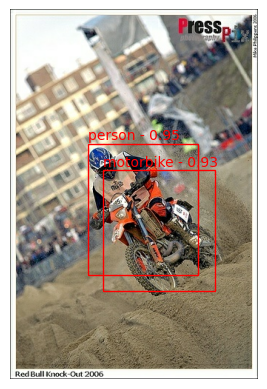

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from akida_models.detection.processing import preprocess_image, decode_output

# Shuffle the data to take a random test image
val_dataset = val_dataset.shuffle(buffer_size=len_val_dataset)

input_shape = model_akida.layers[0].input_dims

# Load the image
raw_image = next(iter(val_dataset))['image']

# Keep the original image size for later bounding boxes rescaling
raw_height, raw_width, _ = raw_image.shape

# Pre-process the image
image = preprocess_image(raw_image, input_shape)
input_image = image[np.newaxis, :].astype(np.uint8)

# Call evaluate on the image
pots = model_akida.predict(input_image)[0]

# Reshape the potentials to prepare for decoding
h, w, c = pots.shape
pots = pots.reshape((h, w, len(anchors), 4 + 1 + len(labels)))

# Decode potentials into bounding boxes
raw_boxes = decode_output(pots, anchors, len(labels))

# Rescale boxes to the original image size
pred_boxes = np.array([[
    box.x1 * raw_width, box.y1 * raw_height, box.x2 * raw_width,
    box.y2 * raw_height,
    box.get_label(),
    box.get_score()
] for box in raw_boxes])

fig = plt.figure(num='VOC detection by Akida')
ax = fig.subplots(1)
img_plot = ax.imshow(np.zeros(raw_image.shape, dtype=np.uint8))
img_plot.set_data(raw_image)

for box in pred_boxes:
    rect = patches.Rectangle((box[0], box[1]),
                             box[2] - box[0],
                             box[3] - box[1],
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)
    class_score = ax.text(box[0],
                          box[1] - 5,
                          f"{labels[int(box[4])]} - {box[5]:.2f}",
                          color='red')

plt.axis('off')
plt.show()